In [27]:
!pip install yfinance

In [28]:
!pip install statsforecast

In [29]:
!pip install prophet

#1. Importação das Bibliotecas

Descrição:
Neste bloco, importamos as bibliotecas essenciais para manipulação e visualização de dados. pandas e numpy são usados para manipulação de dados, enquanto matplotlib e statsmodels ajudam na visualização e análise de séries temporais.



In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
import yfinance as yf
from statsforecast import StatsForecast
from statsforecast.models import  SeasonalNaive, SeasonalWindowAverage, AutoARIMA
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from prophet import Prophet
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
from statsforecast.models import AutoARIMA

In [31]:
#!pip install statsforecast

#2. Carregamento e Visualização Inicial dos Dados

Descrição:
Carregamos os dados históricos do Ibovespa de um arquivo CSV. Em seguida, adicionamos uma coluna chamada 'Chave' para identificar os dados. As funções info(), head() e tail() são usadas para obter uma visão geral do DataFrame, incluindo os tipos de dados e as primeiras e últimas linhas.

In [32]:
dados_ibv = pd.read_csv('/content/Dados_Historicos_Ibovespa.csv', parse_dates=['Data'])

<ipython-input-32-3defcd01e7c9>:1: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [33]:
dados_ibv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      1246 non-null   datetime64[ns]
 1   Último    1246 non-null   float64       
 2   Abertura  1246 non-null   float64       
 3   Máxima    1246 non-null   float64       
 4   Mínima    1246 non-null   float64       
 5   Vol.      1246 non-null   object        
 6   Var%      1246 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 68.3+ KB


In [34]:
print(dados_ibv.head(5))

        Data   Último  Abertura   Máxima   Mínima   Vol.    Var%
0 2024-07-19  127.616   127.652  128.360  127.413  7,62B  -0,03%
1 2024-07-18  127.652   129.450  129.454  127.523  7,59B  -1,39%
2 2024-07-17  129.450   129.112  129.658  128.741  6,67B   0,26%
3 2024-07-16  129.110   129.322  129.521  128.761  6,82B  -0,16%
4 2024-07-15  129.321   128.898  129.485  128.723  5,83B   0,33%


In [35]:
print(dados_ibv.tail(5))

           Data   Último  Abertura   Máxima   Mínima   Vol.    Var%
1241 2019-07-25  102.655   104.119  104.440  102.390  5,98M  -1,41%
1242 2019-07-24  104.120   103.707  104.570  103.707  5,02M   0,40%
1243 2019-07-23  103.704   103.949  104.430  103.518  4,18M  -0,24%
1244 2019-07-22  103.949   103.452  104.278  103.452  3,57M   0,48%
1245 2019-07-19  103.452   104.716  104.723  103.388  3,59M  -1,21%


#3. Preparação dos Dados

Descrição:
Selecionamos e renomeamos as colunas relevantes do DataFrame para preparar os dados para modelagem. As colunas 'Data' e 'Último' são renomeadas para 'ds' e 'y', respectivamente, e a coluna 'Chave' para 'unique_id'. Convertendo 'ds' para o tipo datetime e 'unique_id' para string garante a consistência dos tipos de dados.

In [36]:
# Preparar DataFrame
dados_ibv['Chave'] = 'ibv'
df_1 = dados_ibv[['Data', 'Chave', 'Último']]
df_1 = df_1.rename(columns={'Data': 'ds', 'Último': 'y', 'Chave': 'unique_id'})

##4. Reindexação e Preenchimento de Valores Faltantes

Descrição:
Criamos um intervalo completo de datas para todos os dias úteis entre a primeira e a última data do DataFrame. Reindexamos o DataFrame original para incluir todos esses dias úteis e utilizamos o método ffill() para preencher valores faltantes com o último valor conhecido, garantindo que não haja lacunas nos dados.



In [37]:
# Criar intervalo completo de datas
start_date = df_1['ds'].min()
end_date = df_1['ds'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # Frequência de dias úteis

In [38]:
# Reindexar o DataFrame original para incluir todos os dias úteis
df_1 = df_1.set_index('ds').reindex(all_dates).rename_axis('ds').reset_index()

In [39]:
# Preencher valores faltantes com o último valor conhecido (forward fill)
df_1['y'] = df_1['y'].ffill()

In [40]:
# Definir a coluna 'unique_id'
df_1['unique_id'] = 'ibv'

#5. Visualização dos Dados Preenchidos

Descrição:
Criamos uma visualização dos dados preenchidos para garantir que o preenchimento foi feito corretamente. O gráfico mostra a evolução dos preços de fechamento da bolsa nos últimos cinco anos, com ajustes na aparência para melhorar a legibilidad

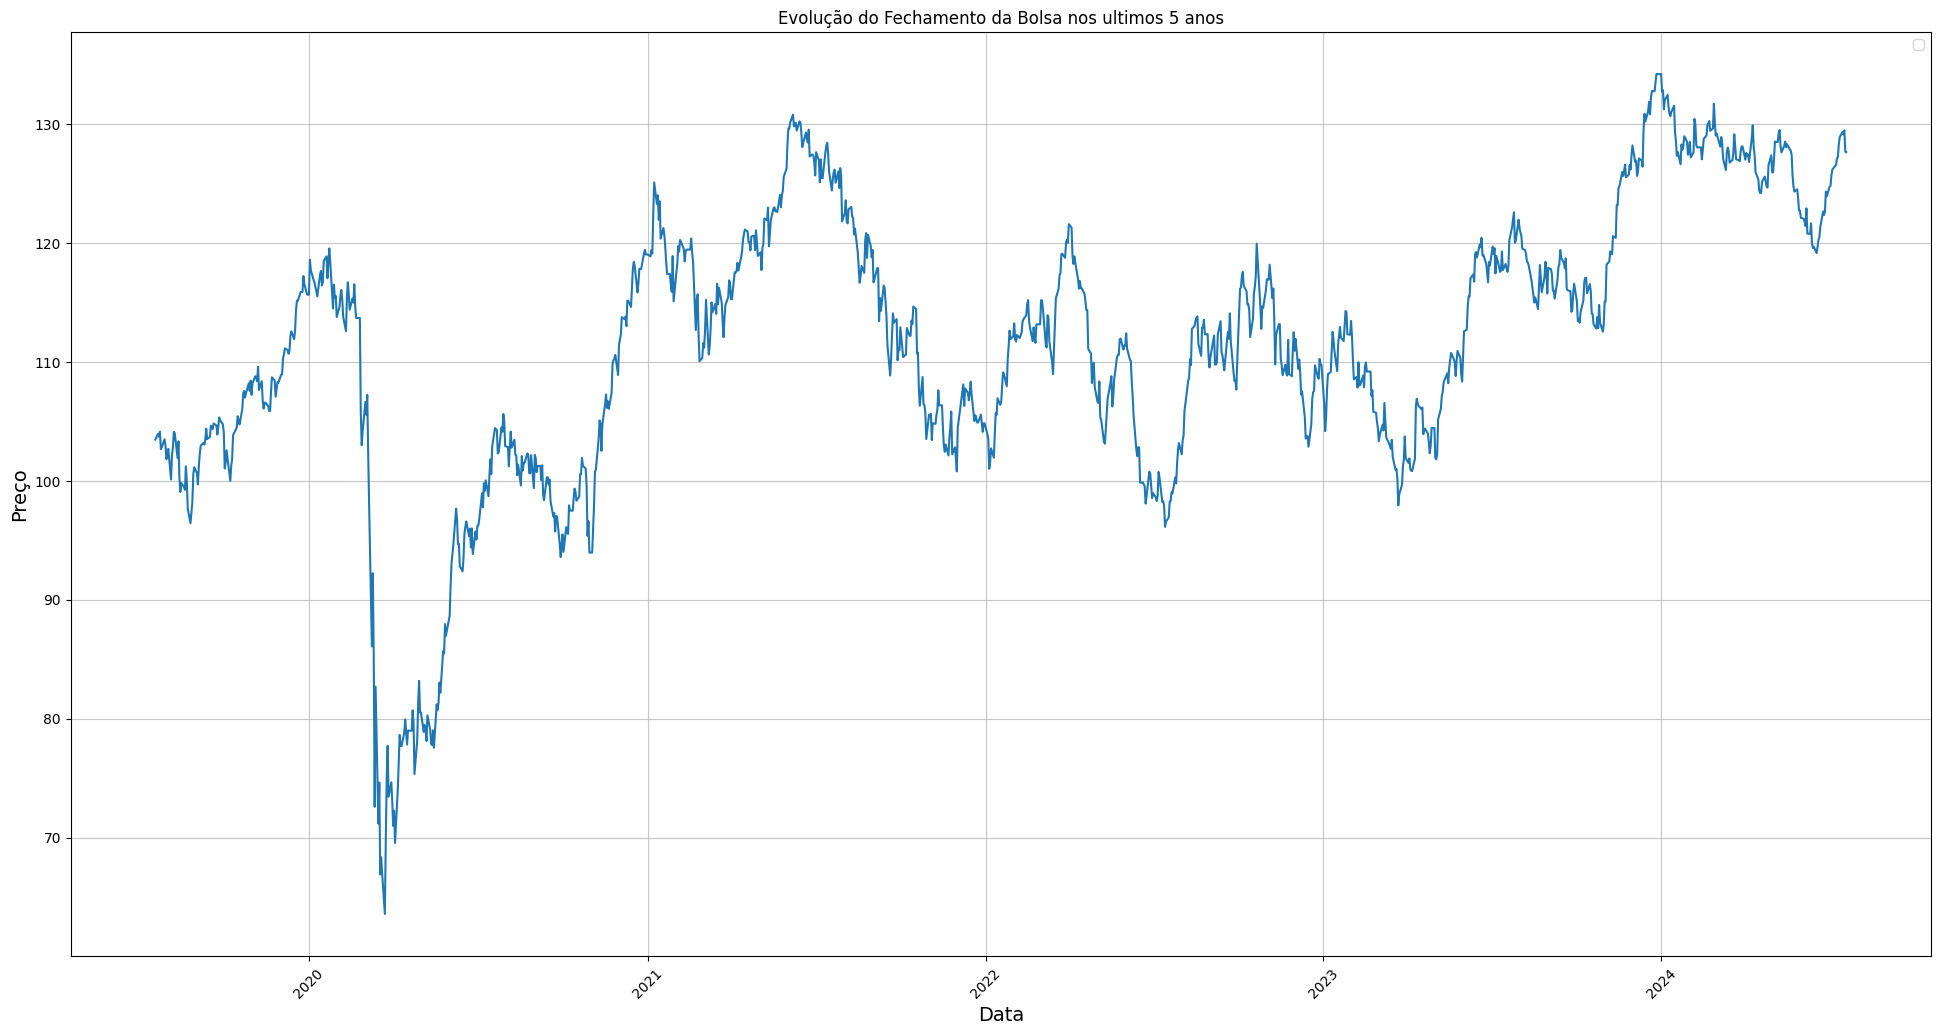

In [41]:
# Visualizar o DataFrame completo para garantir que os dados foram preenchidos corretamente
plt.figure(figsize=(24, 12))
plt.plot(df_1['ds'], df_1['y'])
plt.xlabel('Data', fontsize=14)  # Aumentar o tamanho da fonte dos rótulos dos eixos
plt.ylabel('Preço', fontsize=14)
plt.title('Evolução do Fechamento da Bolsa nos ultimos 5 anos')
plt.grid(True, linestyle='-', alpha=0.7)  # Ajustar o estilo da grade para linhas contínuas
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x para melhor legibilidade
plt.legend()
plt.show()

#Decomposição de Seasonalidade

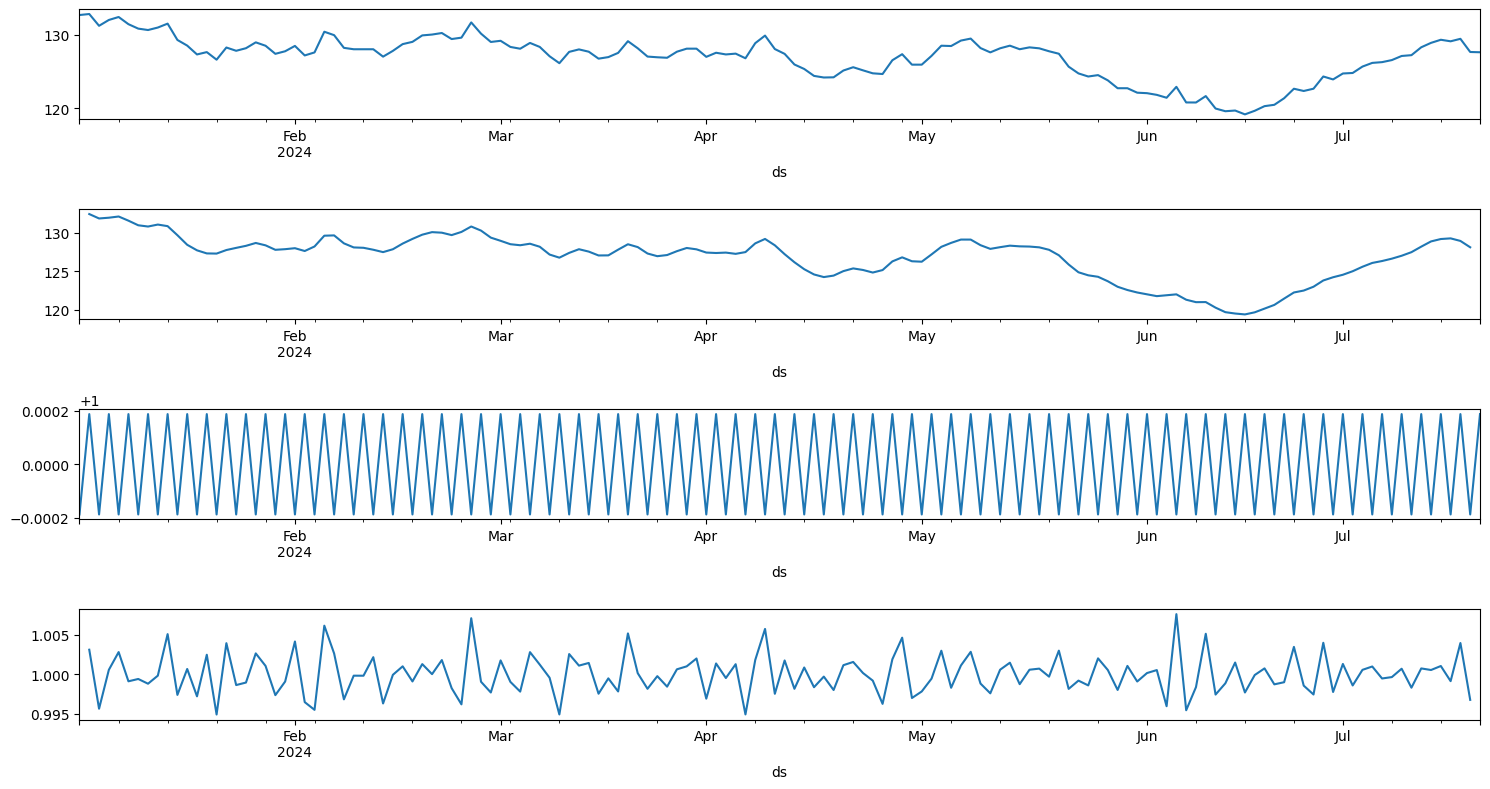

In [42]:
df_2023 = df_1.loc[df_1['ds']  > '2024-01-01']
seasonplot = seasonal_decompose(df_2023.set_index('ds')['y'], model='multiplicative', period=2) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

##6. Definição da Função WMAPE



Descrição:
Definimos uma função para calcular o WMAPE (Weighted Mean Absolute Percentage Error), uma métrica usada para avaliar a precisão das previsões.

In [43]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

#7. Visualização das Previsões

Descrição:

Utilizamos a biblioteca statsforecast para criar previsões com modelos como SeasonalNaive e SeasonalWindowAverage. Para visualizar essas previsões, empregamos a biblioteca plotly.graph_objects para gerar gráficos interativos que mostram tanto os valores reais quanto as previsões, além dos intervalos de confiança quando disponíveis. O WMAPE de cada modelo é calculado e exibido para avaliar a precisão das previsões

Visiualizaçãoem em um intervalo de 365 dias

In [44]:
train = df_1.loc[df_1['ds']  <  '2024-03-18']
valid = df_1.loc[(df_1['ds'] >= '2024-03-18') & (df_1['ds'] <= '2024-07-19')]
h = valid['ds'].nunique()
h

90

#Treino Seasonal Naive

In [66]:
# Ajuste do modelo SeasonalNaive
model_sn = StatsForecast(models=[
                           SeasonalNaive(season_length=h),
                          ],
                       freq='B', n_jobs=-1)
model_sn.fit(train)

# Previsões
forecast_sn = model_sn.predict(h=h)
forecast_sn = forecast_sn.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# Verifique as colunas disponíveis
print("Colunas disponíveis para SeasonalNaive:", forecast_sn.columns)

# Criar gráfico para SeasonalNaive
fig_sn = go.Figure()
for family in ['ibv']:
    df_family_sn = forecast_sn[forecast_sn['unique_id'] == family]

    # Adiciona a linha real
    fig_sn.add_trace(go.Scatter(x=df_family_sn['ds'], y=df_family_sn['y'],
                                mode='lines',
                                name='y',
                                line=dict(width=2)))

    # Adiciona a linha do modelo SeasonalNaive
    if 'SeasonalNaive' in df_family_sn.columns:
        fig_sn.add_trace(go.Scatter(x=df_family_sn['ds'], y=df_family_sn['SeasonalNaive'],
                                    mode='lines',
                                    name='SeasonalNaive'))

fig_sn.update_layout(title='SeasonalNaive Forecast',
                     xaxis_title='Date',
                     yaxis_title='Sales',
                     legend_title='Legend',
                     autosize=True)

fig_sn.show()

# Cálculo e impressão do WMAPE para SeasonalNaive
wmape_sn = wmape(forecast_sn['y'].values, forecast_sn['SeasonalNaive'].values)
MAE_sn=mean_absolute_error(forecast_sn['y'].values, forecast_sn['SeasonalNaive'].values)
MSE_sn = mean_squared_error(forecast_sn['y'].values, forecast_sn['SeasonalNaive'].values)
R2_sn = r2_score(forecast_sn['y'].values, forecast_sn['SeasonalNaive'].values)
#Acc_sn = accuracy_score(forecast_sn['y'].values, forecast_sn['SeasonalNaive'].values)
print(f'SeasonalNaive WMAPE: {wmape_sn:.2%}')
print(f'SeasonalNaive MAE: {MAE_sn}')
print(f'SeasonalNaive MSE: {MSE_sn:.4f}')
print(f'SeasonalNaive R2: {R2_sn:.2f}')

Colunas disponíveis para SeasonalNaive: Index(['unique_id', 'ds', 'SeasonalNaive', 'y'], dtype='object')


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



SeasonalNaive WMAPE: 3.41%
SeasonalNaive MAE: 4.28838915540907
SeasonalNaive MSE: 24.6969
SeasonalNaive R2: -2.07


#Treino SeasWa

In [46]:
train = df_1.loc[df_1['ds']  <  '2024-03-18']
valid = df_1.loc[(df_1['ds'] >= '2024-03-18') & (df_1['ds'] <= '2024-07-19')]
h = valid['ds'].nunique()
h

90

In [47]:
# Ajuste do modelo SeasWA
model_sn = StatsForecast(models=[
                           SeasonalWindowAverage(season_length=h, window_size=2)
                          ],
                       freq='B', n_jobs=-1)
model_sn.fit(train)

# Previsões
forecast_sw = model_sn.predict(h=h)
forecast_sw = forecast_sw.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# Verifique as colunas disponíveis
print("Colunas disponíveis para SeasWA:", forecast_sw.columns)

# Criar gráfico para SeasWA
fig_sn = go.Figure()
for family in ['ibv']:
    df_family_sn = forecast_sw[forecast_sw['unique_id'] == family]

    # Adiciona a linha real
    fig_sn.add_trace(go.Scatter(x=df_family_sn['ds'], y=df_family_sn['y'],
                                mode='lines',
                                name='y',
                                line=dict(width=2)))

    # Adiciona a linha do modelo SeasWA
    if 'SeasWA' in df_family_sn.columns:
        fig_sn.add_trace(go.Scatter(x=df_family_sn['ds'], y=df_family_sn['SeasWA'],
                                    mode='lines',
                                    name='SeasWA'))

fig_sn.update_layout(title='SeasWA Forecast',
                     xaxis_title='Date',
                     yaxis_title='Sales',
                     legend_title='Legend',
                     autosize=True)

fig_sn.show()

# Cálculo e impressão do WMAPE para SeasWA
wmape_sn = wmape(forecast_sw['y'].values, forecast_sw['SeasWA'].values)
print(f'SeasWA WMAPE: {wmape_sn:.2%}')

Colunas disponíveis para SeasWA: Index(['unique_id', 'ds', 'SeasWA', 'y'], dtype='object')


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



SeasWA WMAPE: 2.49%


#Treino Modelo ETS

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



WMAPE: 2.91%


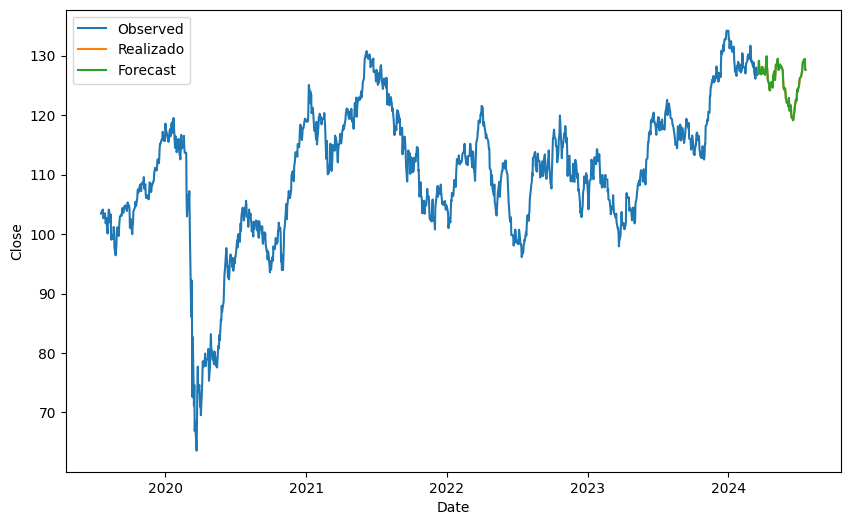

In [48]:
season_length = 252  # Exemplo para dados diários com sazonalidade anual

# Ajustar o modelo ETS (Exponential Smoothing)
model_ets = sm.tsa.ExponentialSmoothing(train['y'], seasonal='mul' , seasonal_periods=season_length).fit()

forecast_ets = model_ets.forecast(h)

forecast_dates = pd.date_range(start=train['ds'].iloc[-1] + pd.Timedelta(days=1), periods=h, freq='B')
forecast_df = pd.DataFrame({'ds': forecast_dates, 'ets': forecast_ets})
forecast_df = forecast_df.merge(valid,on=['ds'],how='inner')
wmape2 = wmape(forecast_df['y'].values, forecast_df['ets'].values)
print(f"WMAPE: {wmape2:.2%}")

# Visualizar as previsões
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Observed')
plt.plot(valid['ds'], valid['y'], label='Realizado')
plt.plot(forecast_df['ds'], forecast_df['y'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [49]:
forecast_df

,ds,ets,unique_id,y
0,2024-03-18,127.345631,ibv,126.954
1,2024-03-19,126.646192,ibv,127.529
2,2024-03-20,126.196008,ibv,129.125
3,2024-03-21,126.504705,ibv,128.159
4,2024-03-22,125.454533,ibv,127.027
...,...,...,...,...
85,2024-07-15,130.326903,ibv,129.321
86,2024-07-16,130.570477,ibv,129.110
87,2024-07-17,131.595488,ibv,129.450
88,2024-07-18,132.152041,ibv,127.652


# Treino Modelo Prophet

In [50]:
from prophet import Prophet
m = Prophet(weekly_seasonality = True)
m.fit(train)
future = m.make_future_dataframe(periods=90)
future.tail()
forecast = m.predict(future)
forecast = forecast.merge(valid,on=['ds'],how='inner')
forecast

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbr9rlg3k/_80houc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbr9rlg3k/sfz7ov4m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81846', 'data', 'file=/tmp/tmpbr9rlg3k/_80houc6.json', 'init=/tmp/tmpbr9rlg3k/sfz7ov4m.json', 'output', 'file=/tmp/tmpbr9rlg3k/prophet_modellqdnemku/prophet_model-20240727193007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:30:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,unique_id,y
0,2024-03-18,129.077879,115.708389,127.590630,129.077879,129.077879,-7.731428,-7.731428,-7.731428,-0.528194,...,-0.528194,-7.203234,-7.203234,-7.203234,0.0,0.0,0.0,121.346451,ibv,126.954
1,2024-03-19,129.132980,115.737443,126.983741,129.132980,129.132980,-7.786392,-7.786392,-7.786392,-0.364519,...,-0.364519,-7.421873,-7.421873,-7.421873,0.0,0.0,0.0,121.346587,ibv,127.529
2,2024-03-20,129.188081,115.421510,127.016471,129.188081,129.188081,-7.908380,-7.908380,-7.908380,-0.322203,...,-0.322203,-7.586177,-7.586177,-7.586177,0.0,0.0,0.0,121.279701,ibv,129.125
3,2024-03-21,129.243182,115.464405,126.783685,129.243182,129.243182,-8.024242,-8.024242,-8.024242,-0.329144,...,-0.329144,-7.695098,-7.695098,-7.695098,0.0,0.0,0.0,121.218940,ibv,128.159
4,2024-03-22,129.298283,115.420137,127.764729,129.298283,129.298283,-8.132499,-8.132499,-8.132499,-0.384068,...,-0.384068,-7.748431,-7.748431,-7.748431,0.0,0.0,0.0,121.165784,ibv,127.027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2024-06-07,133.541065,126.934081,141.729522,129.478693,137.441569,1.231962,1.231962,1.231962,-0.384068,...,-0.384068,1.616030,1.616030,1.616030,0.0,0.0,0.0,134.773027,ibv,120.767
60,2024-06-10,133.706368,127.259634,142.710849,129.439425,137.841079,1.187621,1.187621,1.187621,-0.528194,...,-0.528194,1.715815,1.715815,1.715815,0.0,0.0,0.0,134.893989,ibv,120.760
61,2024-06-11,133.761469,127.673598,142.255664,129.436788,138.013174,1.341338,1.341338,1.341338,-0.364519,...,-0.364519,1.705857,1.705857,1.705857,0.0,0.0,0.0,135.102807,ibv,121.635
62,2024-06-12,133.816570,127.487932,143.155480,129.424111,138.150556,1.353925,1.353925,1.353925,-0.322203,...,-0.322203,1.676128,1.676128,1.676128,0.0,0.0,0.0,135.170496,ibv,119.936


WMAPE: 4.03%


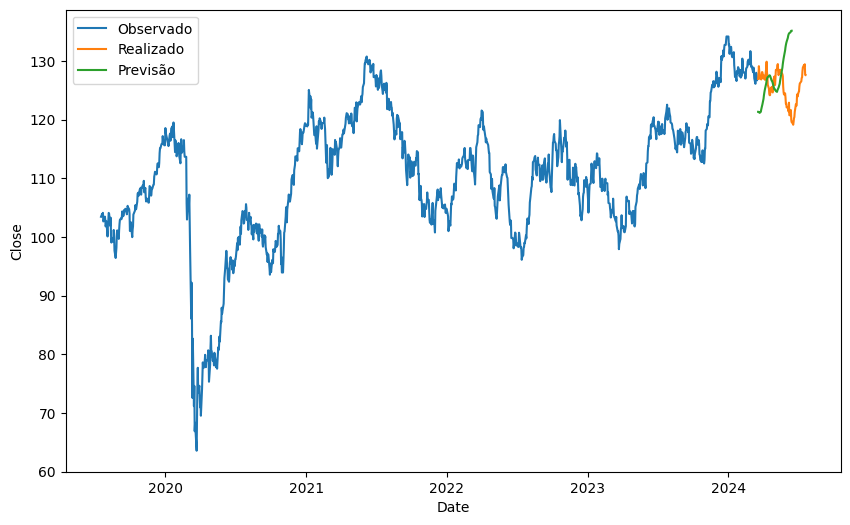

In [51]:
wmape2 = wmape(forecast['y'].values, forecast['yhat'].values)
print(f"WMAPE: {wmape2:.2%}")

# Visualizar as previsões
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Observado')
plt.plot(valid['ds'], valid['y'], label='Realizado')
plt.plot(forecast['ds'], forecast['yhat'], label='Previsão')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

Cross Validation Prophet

# AutoArima

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



WMAPE: 1.87%


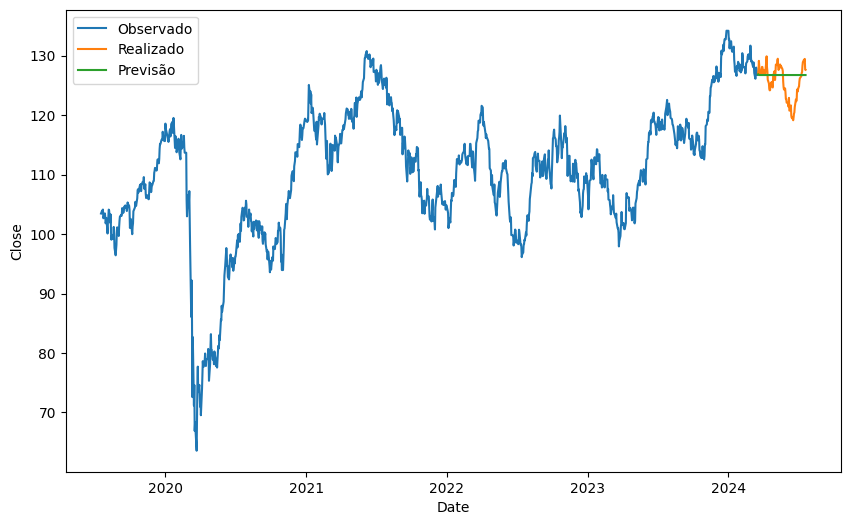

In [54]:
model = StatsForecast(models=[AutoARIMA(season_length=22 )],freq='B',n_jobs=-1)
model.fit(train)

h = valid['ds'].nunique()

forecast_df = model.predict(h=h, level=[90])
forecast_df = forecast_df.merge(valid,on=['ds','unique_id'],how='inner')
wmape2 = wmape(forecast_df['y'].values, forecast_df['AutoARIMA'].values)
print(f"WMAPE: {wmape2:.2%}")

plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Observado')
plt.plot(valid['ds'], valid['y'], label='Realizado')
plt.plot(forecast_df['ds'], forecast_df['AutoARIMA'], label='Previsão')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [55]:
forecast_df

,ds,unique_id,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y
0,2024-03-18,ibv,126.850739,124.238998,129.462479,126.954
1,2024-03-19,ibv,126.773567,123.288719,130.258408,127.529
2,2024-03-20,ibv,126.746269,122.468071,131.024475,129.125
3,2024-03-21,ibv,126.750175,121.763985,131.736359,128.159
4,2024-03-22,ibv,126.744843,121.145531,132.344147,127.027
...,...,...,...,...,...,...
85,2024-07-15,ibv,126.744125,103.007240,150.481018,129.321
86,2024-07-16,ibv,126.744125,102.869263,150.618988,129.110
87,2024-07-17,ibv,126.744125,102.732086,150.756165,129.450
88,2024-07-18,ibv,126.744125,102.595680,150.892563,127.652
